# Объединённая метрика 
## Матрица значений и линейная комбинация

---

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def load_sample(name):
    dt = pd.read_csv(f'../../data/GIAB/_las_noappr/{name}_p14.lasbed', sep=' ')
    dt['Sample'] = name
    return dt

hg = [1,2,3,4] # hg = [1,2,3,4,5,6,7]
LB = pd.concat([load_sample(f'HG00{i}') for i in hg])
LB = LB[LB['covered_bases'] > 0]

# Normalize
fft_m, fft_s = (1783.7347186000002, 263.58889402976223)
dtt_m, dtt_s = (9.111856, 0.06325841730085836)
LB['FFT_dF_n'] = (LB['FFT_dF'] - fft_m)/fft_s
LB['DTCWT_n'] = -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s
LB['DWT_n'] = -LB['DWT_Energy_Entropy']

In [2]:
def separate(T):
    V = [{
      'good': T.loc[(T['covered_bases'] == 1) & (T['acent'] == 0)],
      'bad':  T.loc[(T['covered_bases'] < 1) | (T['acent'] > 0)]
    }]
    V.append({
      'good': V[0]['good'][V[0]['good']['all_diff'] <= 0.8],
      'bad':  V[0]['good'][V[0]['good']['all_diff'] > 0.8]
    })
    V.append({
      'good': V[1]['good'][V[1]['good']['lc_vcf'] == 0],
      'bad':  V[1]['good'][V[1]['good']['lc_vcf'] > 0]
    })
    V.append({
      'good': V[2]['good'][V[2]['good']['hc_vcf'] <= 0.1],
      'bad':  V[2]['good'][V[2]['good']['hc_vcf'] > 0.1]
    })
    return V

LBS = separate(LB)

In [25]:
def hists(A, B):
    l, r = (min(A + B), np.quantile(A + B, 0.995))
    X = np.arange(l, r, (r-l)/80)
    return (np.histogram(A, bins=X)[0], np.histogram(B, bins=X)[0], X)


def tprfpr(A, B):
    dt = np.array([[v, 1] for v in A] + [[v, 0] for v in B])
    dt = dt[dt[:, 0].argsort()]
    tpr = np.cumsum(dt[:, 1])/np.sum(dt[:, 1])
    fpr = np.cumsum(1 - dt[:, 1])/(len(dt) - np.sum(dt[:, 1]))
    return (tpr, fpr, dt)


def acc(A, B, At, Bt):
    tpr, fpr, dt = tprfpr(A, B)
    dst = [(x**2 + (1-y)**2) for x,y in np.transpose([fpr, tpr])]
    t_ = dt[np.argmin(dst)][0]
    At, Bt = (np.array(At), np.array(Bt))
    acc_ = 0.5 * (len(At[At < t_])/len(At) + len(Bt[Bt >= t_])/len(Bt))
    return (acc_, t_)

def getset_of(i, name, of, ignore):
    A, B = (of[i]['good'], of[i]['bad'])
    return (
        A[A['Sample'] != ignore][name].tolist(),
        B[B['Sample'] != ignore][name].tolist(),
        A[A['Sample'] == ignore][name].tolist(),
        B[B['Sample'] == ignore][name].tolist(),
    )

def getset(i, name):
    return getset_of(i, name, LBS, 'HG002')

def fnmax(name):
    accs = []
    axs = plt.figure(figsize=(18, 3), constrained_layout=True).subplots(1, 4)
    for i in range(4):
        A, B, At, Bt = getset(i, name)
        ha, hb, xx = hists(At, Bt)
        axs[i].plot(xx[1:], ha/ha.sum())
        axs[i].plot(xx[1:], hb/hb.sum())
        (acc_, t_) = acc(A, B, At, Bt)
        axs[i].axvline(x=t_, color='red', linestyle='--')
        axs[i].set_title(acc_)
        accs.append(acc_)
    plt.suptitle(f'{name}')
    plt.show()
    return accs

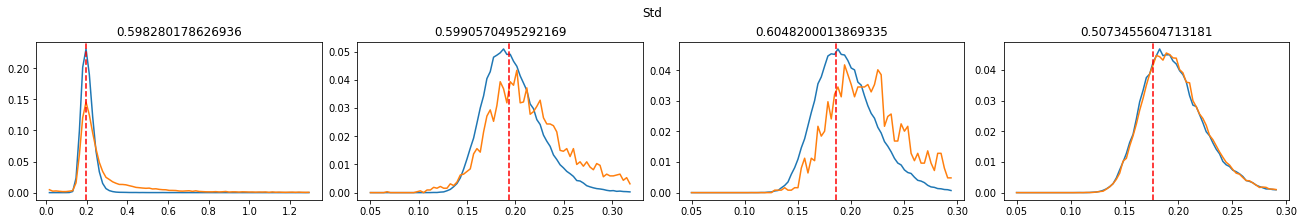

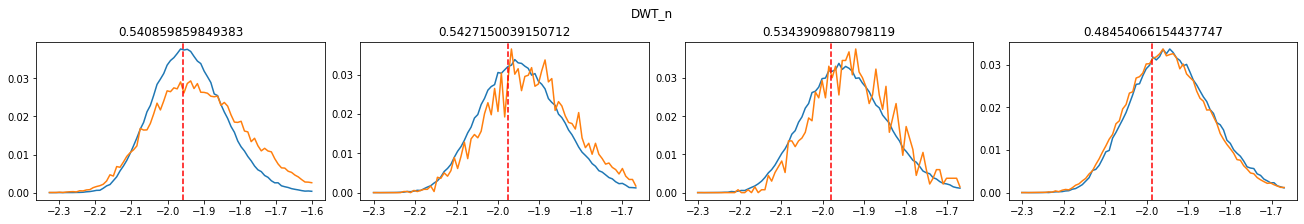

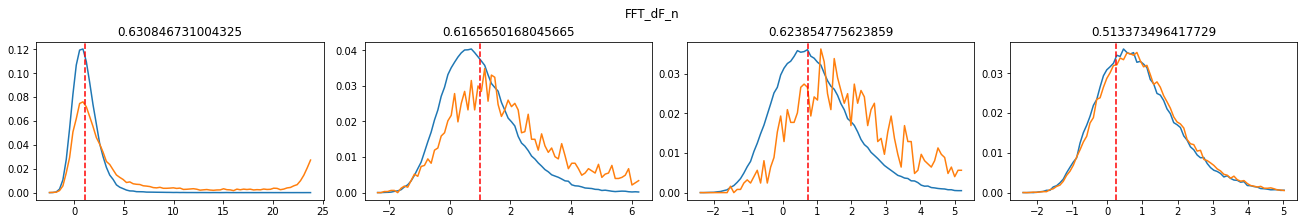

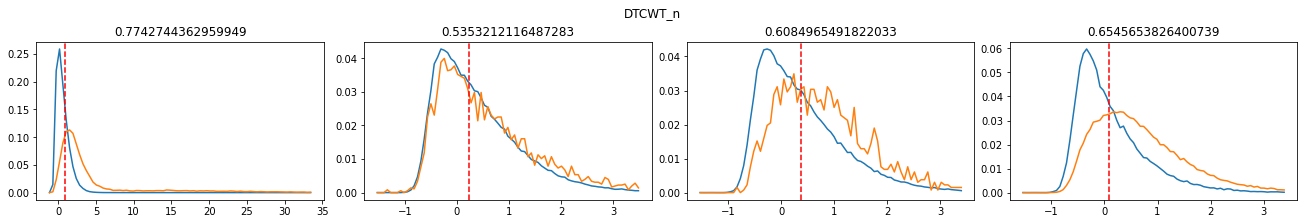

,Std,DWT_n,FFT_dF_n,DTCWT_n
0,0.598280,0.540860,0.630847,0.774274
1,0.599057,0.542715,0.616565,0.535321
2,0.604820,0.534391,0.623855,0.608497
3,0.507346,0.484541,0.513373,0.654565


In [4]:
names = ['Std', 'DWT_n', 'FFT_dF_n', 'DTCWT_n']
df = pd.DataFrame({m:fnmax(m) for m in names})
df

In [5]:
for m in ['DWT_n', 'FFT_dF_n', 'DTCWT_n']:
    pc = (df[m]/df['Std'] - 1).mean()
    print(f"{m:<10} {pc:.1%}")

DWT_n      -8.8%
FFT_dF_n   3.2%
DTCWT_n    12.1%


---

### Матрица значений и размытие

In [6]:
def make_matrix(ts, step):
    xar, yar = (np.arange(-5, 25, step), np.arange(-3, 50, step))
    xl, yl = (len(xar)-1, len(yar)-1)
    n1, n2 = ('FFT_dF_n', 'DTCWT_n')

    counts = []
    for i in range(4):
        A, B = (LBS[i]['bad'], LBS[i]['bad'])
        A, B = (A.loc[A['Sample'] != 'HG002'], B.loc[B['Sample'] != 'HG002'])
        H = np.histogram2d(A[n1], B[n2], bins=(xar, yar))[0]
        counts.append(np.log(H + 1))
    i = 3
    A, B = (LBS[i]['good'], LBS[i]['good'])
    A, B = (A.loc[A['Sample'] != 'HG002'], B.loc[B['Sample'] != 'HG002'])
    H = np.histogram2d(A[n1], B[n2], bins=(xar, yar))[0]
    counts.append(np.log(H + 1))

    tmp = np.zeros((xl, yl))
    for x in range(xl):
        for y in range(yl):
            v = np.array([counts[l][x][y] for l in range(5)])
            #v = np.array([np.log(counts[l][x][y] + 1) for l in range(5)])
            if v.sum() > 0: tmp[x][y] = (v * [0, 1, 2, 3, 4]).sum()

    return tmp, xar, yar

# Globals: mat, xar, yar
def m_index(obj, v):
    if obj[0]  > v: return -2
    if obj[-1] < v: return -1
    return np.where(obj <= v)[0][-1]

def matrix(x, y):
    i, j = (m_index(xar, x), m_index(yar, y))
    if i == -2 or j == -2: return np.max(mat)
    if i == -1 or j == -1: return np.min(mat)
    return mat[i][j]    

In [7]:
# Example
# mat, xar, yar = make_matrix(LBS, 0.3)
# plt.matshow(np.transpose(mat), origin='lower')
# plt.show()

In [8]:
from scipy.ndimage import gaussian_filter
nor7d = np.transpose([LB['FFT_dF_n'], LB['DTCWT_n']])

In [9]:
mat, xar, yar = make_matrix(LBS, 0.3)
LB['matrix_03'] = [-matrix(x_, y_) for x_, y_ in nor7d]
mat = gaussian_filter(mat, sigma=2)
LB['matrix_03b'] = [-matrix(x_, y_) for x_, y_ in nor7d]

mat, xar, yar = make_matrix(LBS, 0.5)
LB['matrix_05'] = [-matrix(x_, y_) for x_, y_ in nor7d]
mat = gaussian_filter(mat, sigma=2)
LB['matrix_05b'] = [-matrix(x_, y_) for x_, y_ in nor7d]

mat, xar, yar = make_matrix(LBS, 1.0)
LB['matrix_10'] = [-matrix(x_, y_) for x_, y_ in nor7d]
mat = gaussian_filter(mat, sigma=2)
LB['matrix_10b'] = [-matrix(x_, y_) for x_, y_ in nor7d]

mat, xar, yar = make_matrix(LBS, 2)
LB['matrix_20'] = [-matrix(x_, y_) for x_, y_ in nor7d]
mat = gaussian_filter(mat, sigma=2)
LB['matrix_20b'] = [-matrix(x_, y_) for x_, y_ in nor7d]

In [11]:
LBS = separate(LB)
df = {}
names = ['Std', 'FFT_dF_n', 'DTCWT_n'] + [m for m in LB.keys().tolist() if m[0:2] == 'ma']
for name in names:
    df[name] = []
    for i in range(4):
        A, B, At, Bt = getset(i, name)
        acc_, t = acc(A, B, At, Bt)
        df[name].append(acc_)
pd.DataFrame(df)

,Std,FFT_dF_n,DTCWT_n,matrix_03,matrix_03b,matrix_05,matrix_05b,matrix_10,matrix_10b,matrix_20,matrix_20b
0,0.598280,0.630847,0.774274,0.766680,0.764335,0.766029,0.756393,0.750028,0.753056,0.773709,0.77479
1,0.599057,0.616565,0.535321,0.611000,0.622686,0.619812,0.624003,0.620042,0.623227,0.603084,0.60262
2,0.604820,0.623855,0.608497,0.616824,0.630122,0.620177,0.626227,0.620253,0.620218,0.622695,0.62271
3,0.507346,0.513373,0.654565,0.552913,0.551933,0.550382,0.565811,0.539464,0.586998,0.585130,0.53020


In [40]:
mat, xar, yar = make_matrix(LBS, 1.0)
mat = gaussian_filter(mat, sigma=2)
with open('_matrix.n1b.json', 'w') as f:
    json.dump([mat.tolist(), xar.tolist(), yar.tolist()], f)

### Упрощенный градиентный спуск на коэффициентах линейной комбинации

In [37]:
import json    

In [28]:
tmp = LB[LB['Sample'] != 'HG002'].copy()
#train = tmp[tmp['Sample'] != 'HG003']
#test = tmp[tmp['Sample'] == 'HG003']

In [29]:
def target(dx, dy, scale):
    tmp['lc'] = scale * (tmp['FFT_dF_n'] + dx)**2 + (tmp['DTCWT_n'] + dy)**2
    tmp_sep = separate(tmp)
    accs = []
    for i in range(4):
        A, B, At, Bt = getset_of(i, 'lc', tmp_sep, 'HG003')
        acc_, t = acc(A, B, At, Bt)
        accs.append(acc_)
    return np.mean(accs)

In [39]:
x_, y_, z_ = (-2, 1, 1)
delta = 0.01
speed = 200
values = []
for step in range(100):
    xl, xr = (target(x_ + delta, y_, z_), target(x_ - delta, y_, z_))
    yl, yr = (target(x_, y_ + delta, z_), target(x_, y_ - delta, z_))
    zl, zr = (target(x_, y_, z_ + delta), target(x_, y_, z_ - delta))
    dx, dy, dz = (xl - xr, yl - yr, zl - zr)
    x_, y_, z_ = (x_ + speed * dx, y_ + speed * dy, z_ + speed * dz)
    vv = np.mean([xl, xr, yl, yr, zl, zr])
    print(f"Step: {step}, dx:{dx:.5f}, dy:{dy:.5f}, dz:{dz:.5f}")
    print(f"NEW: [{x_:.3f}, {y_:.3f}, {z_:.3f}]; V = {vv:.3f}")
    values.append([x_, y_, z_, vv])
    with open("_values.json", "w") as f:
        json.dump(values, f)

Step: 0, dx:0.00081, dy:0.00012, dz:-0.00056
NEW: [-1.837, 1.024, 0.889]; V = 0.626
Step: 1, dx:0.00091, dy:0.00024, dz:-0.00050
NEW: [-1.655, 1.072, 0.789]; V = 0.637
Step: 2, dx:0.00116, dy:0.00037, dz:-0.00037
NEW: [-1.423, 1.146, 0.715]; V = 0.650
Step: 3, dx:-0.00010, dy:0.00066, dz:-0.00077
NEW: [-1.443, 1.278, 0.561]; V = 0.659
Step: 4, dx:0.00014, dy:-0.00184, dz:0.00005
NEW: [-1.415, 0.910, 0.570]; V = 0.660
Step: 5, dx:0.00020, dy:0.00065, dz:-0.00068
NEW: [-1.375, 1.040, 0.435]; V = 0.661
Step: 6, dx:0.00022, dy:0.00019, dz:0.00032
NEW: [-1.331, 1.078, 0.499]; V = 0.663
Step: 7, dx:0.00089, dy:0.00031, dz:-0.00044
NEW: [-1.153, 1.141, 0.411]; V = 0.663
Step: 8, dx:-0.00000, dy:0.00005, dz:0.00023
NEW: [-1.153, 1.152, 0.458]; V = 0.662
Step: 9, dx:0.00011, dy:-0.00042, dz:-0.00021
NEW: [-1.131, 1.067, 0.416]; V = 0.663
Step: 10, dx:0.00010, dy:-0.00018, dz:0.00034
NEW: [-1.111, 1.031, 0.485]; V = 0.664
Step: 11, dx:0.00014, dy:-0.00012, dz:0.00088
NEW: [-1.083, 1.008, 0.662];

KeyboardInterrupt: 